In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Sep  15 08:50:58 2021
@author: zeqinhuang
"""

import xarray as xr
import numpy as np
import pandas as pd
import os
import proplot as pplot
import cmaps
from matplotlib import pyplot as plt
from scipy.stats import norm
import glob
import matplotlib as mpl
import xesmf as xe
from cartopy.util import add_cyclic_point
from scipy.stats import linregress
from scipy.stats import theilslopes
import geopandas as gp
import seaborn as sns
import random
from warnings import simplefilter

import sys
sys.path.append('../')

import matplotlib.patches as pch
import cartopy
import cartopy.crs as ccrs
mapcrs = ccrs.PlateCarree(central_longitude=0, globe=None)
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from utils import *
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

simplefilter(action='ignore', category=FutureWarning)

In [2]:
def extract_roi_var(name,forcing,mask='Global', for_satellite=True):
    ensemble = ensembles[forcing]
    ensemble = [i+'_'+filepath[-12:-3] for i in ensemble for filepath in glob.glob(forcing_dir[forcing] + name + '_day_' + i + '*.nc')]
    
    i = ensemble[0]
    src_id = i.split('_')[0]
    run    = i.split('_')[2]
    pi_time = i.split('_')[3]
    ens_i  = Rx1dayCond(name,forcing,src_id,run,mask=mask,pi_time=pi_time,for_sn=True,for_satellite=True)
    ens_i_regridded = ens_i.regrid()
    area_weights = np.cos(np.deg2rad((ens_i_regridded.lat)))
    area_weights.name = 'weights'
    ens_i_regrid = ens_i.regrid()
    ens_i_regrid_weighted = ens_i_regrid.weighted(area_weights)
    ens_i_weighted_mean = ens_i_regrid_weighted.mean(("lon", "lat"))
    ens_i_weighted_mean = ens_i_weighted_mean[var_name[name]]
    ens_weighted_mean = pd.DataFrame(ens_i_weighted_mean,index=ens_i_weighted_mean.time,columns=[i])
    
    for i in ensemble:
        if i == ensemble[0]:
            pass
        else: 
            src_id = i.split('_')[0]
            run    = i.split('_')[2]
            pi_time = i.split('_')[3]
            ens_i  = Rx1dayCond(name,forcing,src_id,run,mask=mask,pi_time=pi_time,for_sn=True,for_satellite=True)
            ens_i_regridded = ens_i.regrid()
            area_weights = np.cos(np.deg2rad((ens_i_regridded.lat)))
            area_weights.name = 'weights'
            ens_i_regrid = ens_i.regrid()
            ens_i_regrid_weighted = ens_i_regrid.weighted(area_weights)
            ens_i_weighted_mean = ens_i_regrid_weighted.mean(("lon", "lat"))
            ens_i_weighted_mean = ens_i_weighted_mean[var_name[name]]
            ens_i_weighted_mean = pd.DataFrame(ens_i_weighted_mean,index=range(1951,1951+len(ens_i_weighted_mean)),columns=[i])
            ens_weighted_mean = pd.concat([ens_weighted_mean,ens_i_weighted_mean], axis=1)
    file_path = forcing_dir[forcing] + name + '_ens_weighted_mean_' + mask + '.csv'
    ens_weighted_mean.to_csv(file_path)
        
def cal_slope(time_series):
    ts_slope = linregress(range(len(time_series)),time_series).slope
    return ts_slope

def get_ens_weighted_mean_for_mask(name,forcing,mask):
    path = forcing_dir[forcing] + name + '_ens_weighted_mean_' + mask + '.csv'
    ens_weighted_mean = pd.read_csv(path,index_col=0)
    return ens_weighted_mean

def get_singal(name,forcing,mask,L_length):
    ensemble = ensembles[forcing]
    ensemble = [i+'_'+filepath[-12:-3] for i in ensemble for filepath in glob.glob(forcing_dir[forcing] + name + '_day_' + i + '*.nc')]
    if forcing == 'piControl':
        ensemble = ensemble[1:]
    prec_ens_weighted_mean = get_ens_weighted_mean_for_mask(name,forcing,mask=mask)
    prec_ens_weighted_mean = prec_ens_weighted_mean[ensemble]
    trends = []
    for e in ensemble:
        prec_weighted_mean_e = prec_ens_weighted_mean[e]
        for i in range(len(prec_weighted_mean_e) - L_length + 1):
            prec_weighted_mean_e_i = prec_weighted_mean_e.iloc[i:i+L_length]
            trend = cal_slope(prec_weighted_mean_e_i)
            trends.append(trend)
    return trends

def get_noise(name,mask,L_length):
    forcing = 'piControl'
    ensemble = ensembles[forcing]
    ensemble = [i+'_'+filepath[-12:-3] for i in ensemble for filepath in glob.glob(forcing_dir[forcing] + name + '_day_' + i + '*.nc')]
    ensemble = ensemble[1:]
    prec_ens_weighted_mean = get_ens_weighted_mean_for_mask(name,forcing,mask=mask)
    prec_ens_weighted_mean = prec_ens_weighted_mean[ensemble]
    trends = []
    for e in ensemble:
        prec_weighted_mean_e = prec_ens_weighted_mean[e]
        for i in range(len(prec_weighted_mean_e) - L_length + 1):
            prec_weighted_mean_e_i = prec_weighted_mean_e.iloc[i:i+L_length]
            trend = cal_slope(prec_weighted_mean_e_i)
            trends.append(trend)
    trends = pd.Series(trends)
    noise = trends.std()
    return noise

def cal_5year_moving_avg(time_series):
    time_series = time_series.rolling(5,center=True,min_periods=1,axis=0).mean()
    return time_series

def cal_sig(time_series):
    ts_sig   = linregress(range(len(time_series)),time_series).pvalue
    if ts_sig <= 0.05:
        ts_sig = True
    else:
        ts_sig = False
    return ts_sig

from sklearn.utils import resample ## bootstrap sampling
def bs_sample_std(a,iter_nums=1000):
    data_stds = []
    for i in range(iter_nums):
        data_stds.append(resample(a,n_samples=len(a),replace=True).std())
    data_mean_std = np.mean(data_stds)
    return data_mean_std

def get_ens_weighted_for_mask(name,forcing,mask='EU'):
    
    path = forcing_dir[forcing] + name + '_ens_weighted_mean_' + mask + '.csv'
    ens_weighted_mean = pd.read_csv(path,header=0,index_col=0)
    data_trend = ens_weighted_mean.apply(cal_slope,axis=0) * 10
    mme = ens_weighted_mean.mean(axis=1)
    mme_trend = cal_slope(mme) * 10
    mme_trend_sig = cal_sig(mme)
    ens_weighted_mean = cal_5year_moving_avg(ens_weighted_mean)
    mme = cal_5year_moving_avg(mme)
    mme_ano = mme - mme.mean()
    ens_weighted_mean_ano = ens_weighted_mean - ens_weighted_mean.mean(axis=0)
    ens_weighted_mean_005 = ens_weighted_mean_ano.apply(lambda x: x.quantile(0.05),axis=1)
    ens_weighted_mean_095 = ens_weighted_mean_ano.apply(lambda x: x.quantile(0.95),axis=1)
    data_trend_std = bs_sample_std(data_trend)

    return mme_ano, mme_trend, mme_trend_sig, data_trend_std, ens_weighted_mean_005, ens_weighted_mean_095

def get_reanalysis_weighted_for_mask(name,forcing,mask='EU'):
    prec = Rx1dayCond(name=name,forcing=forcing,src_id=forcing,run='reanalysis',mask=mask,for_satellite=True)
    reanalysis_regridded = prec.regrid()
    area_weights = np.cos(np.deg2rad((reanalysis_regridded.lat)))
    area_weights.name = 'weights'
    reanalysis_regridded = reanalysis_regridded.weighted(area_weights)
    reanalysis_regridded = reanalysis_regridded.mean(("lon", "lat"))
    reanalysis_regridded = reanalysis_regridded[var_name[name]]

    reanalysis_trend = cal_slope(reanalysis_regridded) * 10
    reanalysis_trend_sig = cal_sig(reanalysis_regridded)
    reanalysis_regridded = cal_5year_moving_avg(reanalysis_regridded.to_dataframe())
    reanalysis_regridded_ano = reanalysis_regridded - reanalysis_regridded.mean()
    reanalysis_regridded_ano = reanalysis_regridded_ano.values

    return reanalysis_trend, reanalysis_trend_sig,reanalysis_regridded_ano

def get_hadex3_weighted_for_mask(mask):
    hadex_rx1day_sel = hadex_rx1day * hadex_rx1day_grid_sel
    area_weights = np.cos(np.deg2rad((hadex_rx1day_sel.lat)))
    area_weights.name = 'weights'
    if mask == 'EU':
        hadex_mask = hadex_rx1day_sel * mask_EU
    elif mask == 'EAS':
        hadex_mask = hadex_rx1day_sel * mask_EAS
    elif mask == 'NA':
        hadex_mask = hadex_rx1day_sel * mask_NA
    elif mask == 'SSA':
        hadex_mask = hadex_rx1day_sel * mask_SSA
    elif mask == 'AU':
        hadex_mask = hadex_rx1day_sel * mask_AU
    else:
        pass
    hadex_mas_weighted = hadex_mask.weighted(area_weights)

    hadex_weighted_mean = hadex_mas_weighted.mean(("lon", "lat"),skipna=True).to_dataframe()
    hadex_weighted_mean = hadex_weighted_mean['Rx1day'] 
    hadex_trend = cal_slope(hadex_weighted_mean) * 10
    hadex_trend_sig = cal_sig(hadex_weighted_mean)
    hadex_weighted_mean = cal_5year_moving_avg(hadex_weighted_mean)
    hadex_weighted_ano = hadex_weighted_mean - hadex_weighted_mean.mean()
    hadex_weighted_ano = hadex_weighted_ano.values

    return hadex_trend, hadex_trend_sig, hadex_weighted_ano

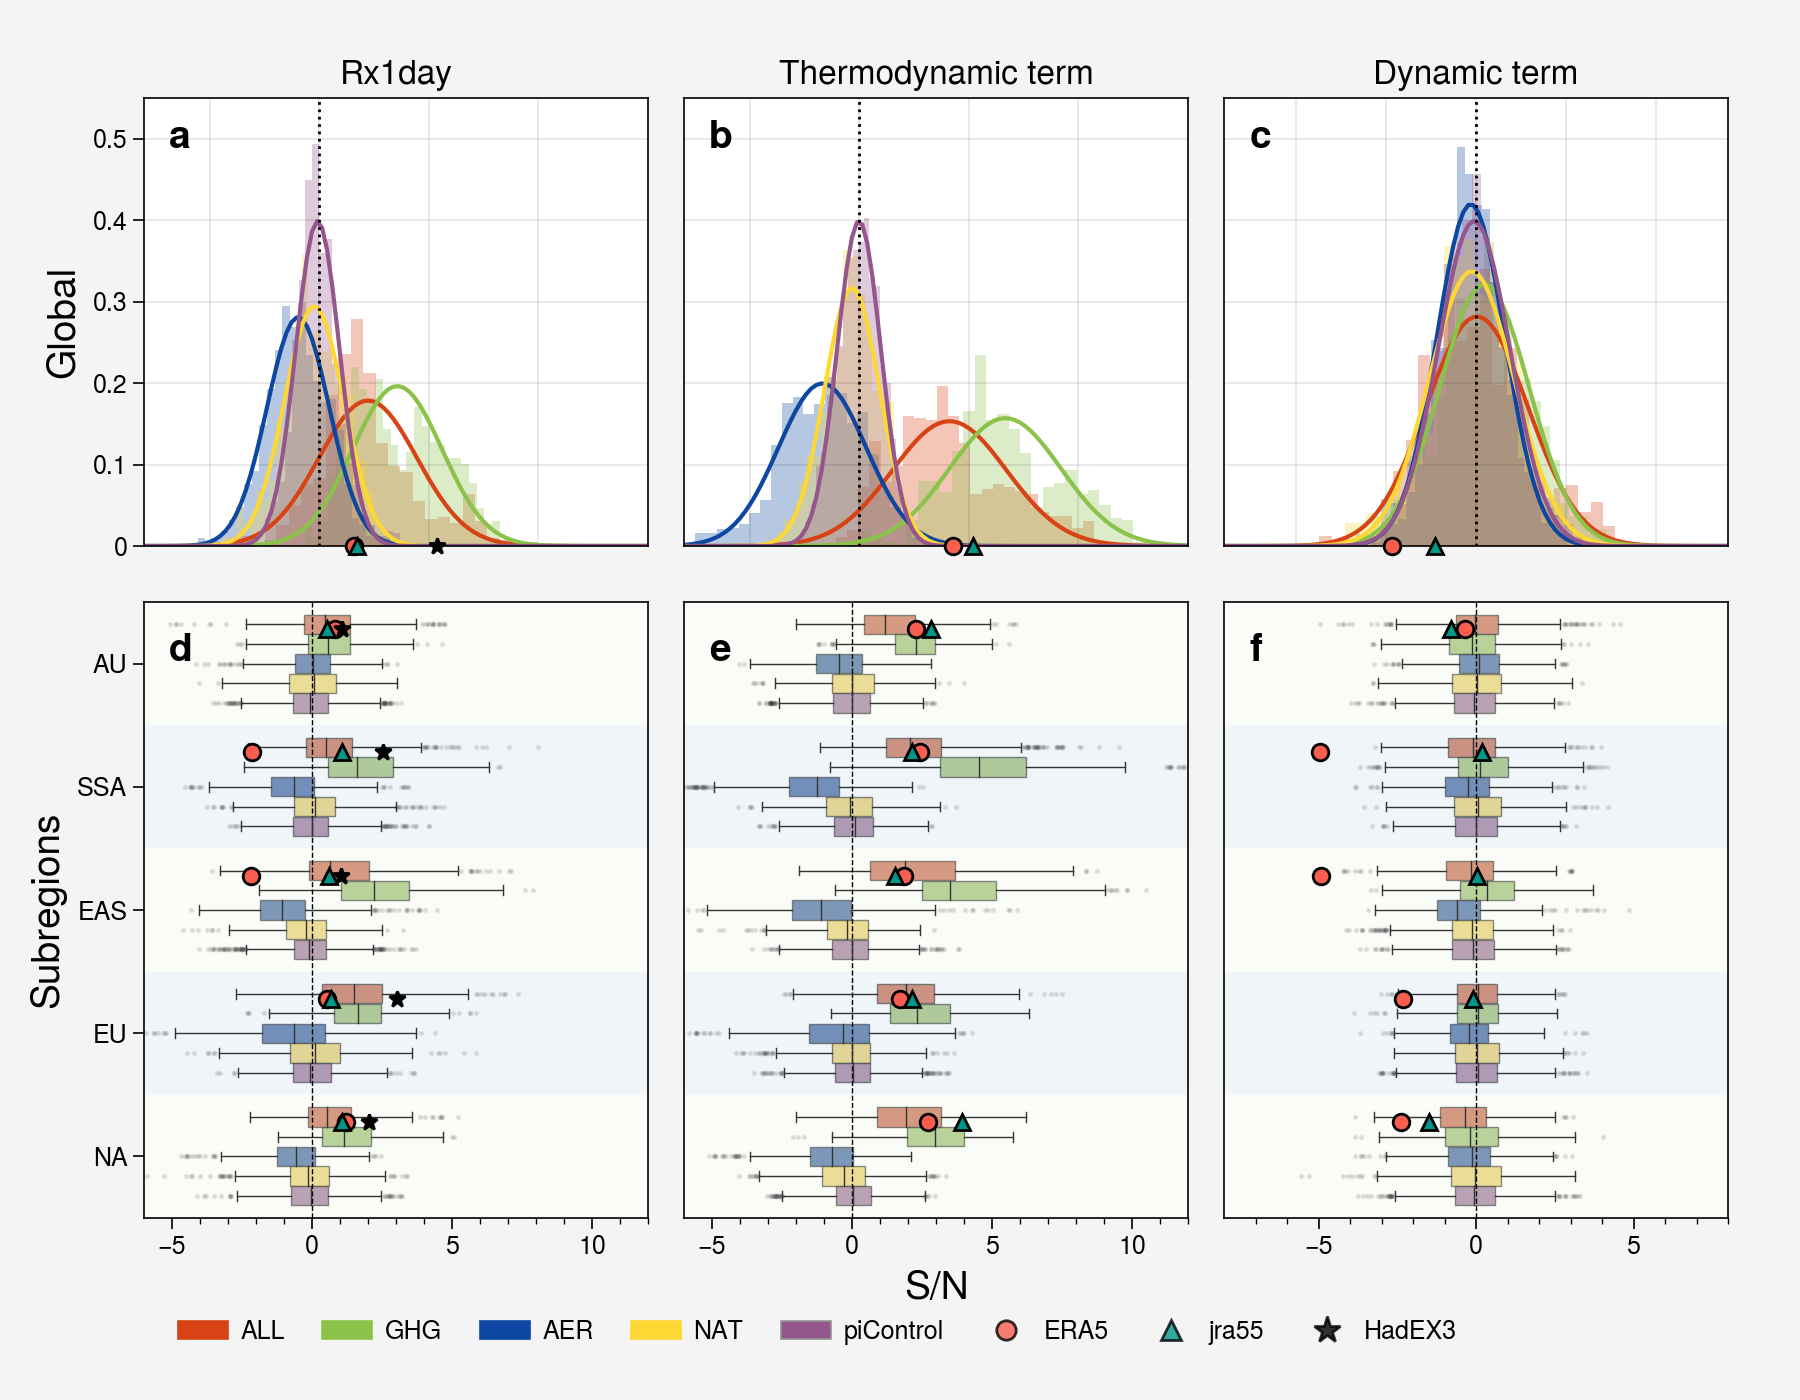

In [3]:
name_list    = ['prec','scaling_thermo','scaling_dynamic']
name_list2 = ['prec_cond','scaling_thermo','scaling_dynamic']
colors = {'era5':'#F75E50','jra55':'#009688','ncep2':'#436A64', 'hadex3':'black','historical':'#D84315','hist-GHG':'#8BC34A','hist-aer':'#0D47A1','hist-nat':'#FDD835','piControl':'purple'}
y_delta = {'historical':0.82,'hist-GHG':0.66,'hist-aer':0.5,'hist-nat':0.34,'piControl':0.18}

import seaborn as sns

def add_panel_label(ax, label, x = -0.1, y = 1.15):
    ax.text(x, y, label, transform=ax.transAxes,
      fontsize=14, fontweight='bold', va='top', ha='left')

fig = plt.figure(figsize = (9, 7))

ax_anchor = [
    [0.08,0.61,0.28,0.32],
    [0.38,0.61,0.28,0.32],
    [0.68,0.61,0.28,0.32],
    [0.08,0.13,0.28,0.44],
    [0.38,0.13,0.28,0.44],
    [0.68,0.13,0.28,0.44]
]
abc_label = ['a','b','c','d','e','f']
sub_regions = ['NA','EU','EAS','SSA','AU'][::-1]

# raw1
L = 36
for i in range(3):
    axi = fig.add_axes(ax_anchor[i])
    name = name_list[i]
    if i == 0:
        forcings = ['era5','jra55','hadex3','historical','hist-GHG','hist-aer','hist-nat','piControl']
    else:
        forcings = ['era5','jra55','historical','hist-GHG','hist-aer','hist-nat','piControl']

    noise = get_noise(name,mask='Global',L_length=L)

    for f in forcings:
        if f == 'era5':
            prec_era5 = Rx1dayCond(name=name,forcing='era5',src_id='era5',run='reanalysis',mask='Global', for_satellite=True)
            prec_era5 = prec_era5.regrid()
            prec_era5 = prec_era5.sel(time=slice('1979','2014'))
            area_weights = np.cos(np.deg2rad((prec_era5.lat)))
            area_weights.name = 'weights'
            prec_weighted = prec_era5.weighted(area_weights)
            prec_weighted_mean = prec_weighted.mean(("lon", "lat"),skipna=True)
            trend_era5 = cal_slope(prec_weighted_mean[name_list2[i]].values)
            axi.plot([trend_era5/noise],[0],"o",markerfacecolor=colors['era5'],markeredgecolor='black',alpha=1,markersize=6,clip_on=False,zorder=3)
        elif f == 'jra55':
            prec_jra55 = Rx1dayCond(name=name,forcing='jra55',src_id='jra55',run='reanalysis',mask='Global', for_satellite=True)
            prec_jra55 = prec_jra55.regrid()
            prec_jra55 = prec_jra55.sel(time=slice('1979','2014'))
            area_weights = np.cos(np.deg2rad((prec_jra55.lat)))
            area_weights.name = 'weights'
            prec_weighted = prec_jra55.weighted(area_weights)
            prec_weighted_mean = prec_weighted.mean(("lon", "lat"),skipna=True)
            trend_jra55 = cal_slope(prec_weighted_mean[name_list2[i]].values)
            axi.plot([trend_jra55/noise],[0],"^",markerfacecolor=colors['jra55'],markeredgecolor='black',alpha=1,markersize=6,clip_on=False,zorder=3)
        elif f == 'hadex3':
            hadex_rx1day_sel = hadex_rx1day * hadex_rx1day_grid_sel
            area_weights = np.cos(np.deg2rad((hadex_rx1day_sel.lat)))
            area_weights.name = 'weights'
            hadex_weighted = hadex_rx1day_sel.weighted(area_weights)
            hadex_weighted_mean = hadex_weighted.mean(("lon", "lat"),skipna=True).to_dataframe()
            hadex_weighted_mean = hadex_weighted_mean.loc['1979-07-01':'2014-07-01']
            trend_hadex = hadex_weighted_mean.apply(cal_slope)[0]
            axi.plot([trend_hadex/noise],[0],"*",markerfacecolor=colors['hadex3'],markeredgecolor='black',alpha=1,markersize=6,clip_on=False,zorder=3)
        else:
            trends = pd.Series(get_singal(name,f,mask='Global', L_length=L))
            s2n = trends / noise
            if f == 'historical':
                hist_noise = noise
            else:
                pass
            mu, std = norm.fit(s2n)
            axi.hist(s2n, bins=25, density=True, alpha=0.3, color=colors[f])

            xmin, xmax = axi.get_xlim()
            x = np.linspace(xmin, xmax, 100)
            p = norm.pdf(x, mu, std)
            axi.plot(x, p, linewidth=1.5, color=colors[f])
        if i != 2:
            axi.set(xlim=(-8,15))
            axi.set(ylim=(0,0.55))
        else:
            axi.set(xlim=(-7,7))
            axi.set(ylim=(0,0.55))
        if i == 0:
            axi.set_ylabel('Global',fontsize=14)
    axi.axvline(x=0,ls=":",lw=1,c='black')
    axi.xaxis.set_tick_params(which='minor', bottom=False)
    axi.yaxis.set_tick_params(which='minor', left=False)
    axi.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
    add_panel_label(axi, abc_label[i], x = 0.05, y = 0.95)

    if i == 0:
        axi.set_title('Rx1day',fontdict={'fontsize':12, 'fontweight':'medium'})    
    if i == 1:
        axi.set_title('Thermodynamic term',fontdict={'fontsize':12, 'fontweight':'medium'})
        axi.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
    if i == 2:
        axi.set_title('Dynamic term',fontdict={'fontsize':12, 'fontweight':'medium'})
        axi.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
    
# raw2 for subregions
s2n_all = pd.DataFrame()
for i in range(3): # for ['prec','scaling_thermo','scaling_dynamic']
    name = name_list[i]
    forcings = ['historical','hist-GHG','hist-aer','hist-nat','piControl']
    sub_regions = ['NA','EU','EAS','SSA','AU'][::-1]

    for s in range(5):
        sub_region = sub_regions[s]
        noise = get_noise(name,mask=sub_region,L_length=L)
        for f in forcings:
            trends = pd.Series(get_singal(name,f,mask=sub_region,L_length=L))
            s2n = trends / noise
            s2n = pd.DataFrame(s2n,columns=['S/N'])
            s2n['region'] = sub_region
            s2n['forcing'] = f
            s2n['name'] = name
            s2n_all = s2n_all.append(s2n)

for i in range(3):
    axi = fig.add_axes(ax_anchor[i+3])
    axi.grid(False)
    name = name_list[i-3]

    axi.barh([0,1,2,3,4],[20,20,20,20,20],height=1,color=['#e9f4df','#b3cde3','#e9f4df','#b3cde3','#e9f4df'],alpha=0.2)
    axi.barh([0,1,2,3,4],[-20,-20,-20,-20,-20],height=1,color=['#e9f4df','#b3cde3','#e9f4df','#b3cde3','#e9f4df'],alpha=0.2)
    axi.set(ylim=(0,4))
    axi.set_yticks([0.5,1.5,2.5,3.5,4.5])
    axi.yaxis.set_tick_params(which='minor', left=False)

    sns.boxplot(
        x='S/N',y='region',hue='forcing',data=s2n_all[s2n_all['name']==name],linewidth=0.5,width=0.8,
        palette=['#D84315','#8BC34A','#0D47A1','#FDD835','purple'],boxprops=dict(alpha=0.7),
        flierprops = dict(marker='o', markersize=1,color='gray',alpha=0.1),ax=axi)
    if i == 0:
        axi.set_ylabel('Subregions',fontdict={'fontsize':14})
    else:
        axi.yaxis.label.set_visible(False)
    if i in [1,2,4,5]:
        axi.set_yticks([])
    axi.axvline(x=0,ls="dashed",lw=0.5,c='black')
    axi.get_legend().remove()

    if i != 2:
        axi.set(xlim=(-6,12))
    else:
        axi.set(xlim=(-8,8))
    add_panel_label(axi, abc_label[i+3], x = 0.05, y = 0.95)

    ##### plot era5 scatter
    for s in range(5):
        name = name_list[i]
        sub_region = sub_regions[s]
        noise = get_noise(name,mask=sub_region,L_length=36)

        trend, _, _ = get_reanalysis_weighted_for_mask(name=name,forcing='era5',mask=sub_region)
        trend = trend / 10
        axi.plot([trend/noise],[s+y_delta['historical']-1.1],"o",markerfacecolor=colors['era5'],markeredgecolor='black',alpha=1,markersize=6,zorder=3)

    ##### plot jra55 scatter
    for s in range(5):
        name = name_list[i]
        sub_region = sub_regions[s]
        noise = get_noise(name,mask=sub_region,L_length=36)

        trend, _, _ = get_reanalysis_weighted_for_mask(name=name,forcing='jra55',mask=sub_region)
        trend = trend / 10
        axi.plot([trend/noise],[s+y_delta['historical']-1.1],"^",markerfacecolor=colors['jra55'],markeredgecolor='black',alpha=1,markersize=6,zorder=3)

    ##### plot hadex3 scatter
    if i == 0:
        for s in range(5):
            sub_region = sub_regions[s]
            hadex_trend, _, _ = get_hadex3_weighted_for_mask(mask=sub_region)
            hadex_trend = hadex_trend / 10
            noise = get_noise(name,mask=sub_region,L_length=36)
            axi.plot([hadex_trend/noise],[s+y_delta['historical']-1.1],"*",markerfacecolor=colors['hadex3'],markeredgecolor='black',alpha=1,markersize=6,zorder=3)
    else:
        pass

    if i == 1:
        axi.set_xlabel('S/N',fontsize=14)
    else:
        axi.xaxis.label.set_visible(False)

# ax.format(rightlabels=('Global', 'Subregion'),toplabels=('Rx1day','Thermodynamic scaling','Dynamic scaling'))

from matplotlib.lines import Line2D
labels = ['ALL','GHG','AER','NAT','piControl','ERA5','jra55','HadEX3'] 
legend_elements = [
    Patch(facecolor=colors['historical'], edgecolor=colors['historical'],label='ALL'),
    Patch(facecolor=colors['hist-GHG'], edgecolor=colors['hist-GHG'],label='GHG'),
    Patch(facecolor=colors['hist-aer'], edgecolor=colors['hist-aer'],label='AER'),
    Patch(facecolor=colors['hist-nat'], edgecolor=colors['hist-nat'],label='NAT'),
    Patch(facecolor=colors['piControl'], edgecolor='gray',label='piControl'),
    Line2D([0], [0], marker='o' ,color='none',markerfacecolor=colors['era5'], label='ERA5',alpha=0.8,markersize=7),
    Line2D([0], [0], marker='^' ,color='none',markerfacecolor=colors['jra55'], label='jra55',alpha=0.8,markersize=7),
    Line2D([0], [0], marker='*' ,color='none',markerfacecolor=colors['hadex3'], label='HadEX3',alpha=0.8,markersize=10),]
handles = legend_elements
axi.legend(handles,labels,frameon=False,ncol=9,loc=2,bbox_to_anchor=[-2.1,-0.145],fontsize = 'medium', fancybox = False)

fig_dir = '/Users/zeqinhuang/Documents/paper/prec_scaling_da/scaling_script/plotScript/scaling_plot_NW/Figures/'
fig.savefig(fig_dir+'FigS12_detection_and_attribution_satellite_era_ERA5_JRA55.pdf')